# Test code for skull extraction using FSL BET 
- Uses neurodocker+nipype: https://miykael.github.io/nipype_tutorial/notebooks/introduction_docker.html
- Code examples: 
    - https://github.com/miykael/nipype_tutorial/blob/master/notebooks/basic_data_input.ipynb
    - https://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.fsl/preprocess.html

In [33]:
# imports
import os
import numpy as np
from nilearn import image as nli
import nipype.interfaces.io as nio
import nibabel as nib
from nilearn.plotting import plot_epi
import matplotlib.pyplot as plt
from skimage import measure
import collections
import pandas as pd
%matplotlib inline
from nipype.interfaces import fsl

In [12]:
# Paths
data_dir = '/home/neuro/nipype_tutorial/data/input/'
#test_img = data_dir + 'sub_04/t1w_04.nii.gz'


# Input data

In [13]:
# List of subjects
sub_dirs = os.listdir(data_dir)
sub_idx = []
for d in sub_dirs:
    sub_idx.append(d.split('_')[1])

# Run BET with skull extraction

In [90]:
# Mask the subject image 
save_masked_img = False
for idx in sub_idx:
    subject_dir = data_dir + 'sub_{}/'.format(idx)
    subject_img_file = subject_dir + 't1w_{}.nii.gz'.format(idx)

    btr = fsl.BET()
    btr.inputs.in_file = subject_img_file
    btr.inputs.frac = 0.25
    btr.inputs.mask = True
    btr.inputs.skull = True
    btr.inputs.surfaces = True
    
    btr.inputs.out_file = subject_dir + 'BET_brain_anat_{}.nii'.format(idx)
    res = btr.run() 

181130-04:01:08,680 nipype.interface INFO:
	 stderr 2018-11-30T04:01:08.680291:Image Exception : #22 :: ERROR: Could not open image /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm
181130-04:01:08,681 nipype.interface INFO:
	 stderr 2018-11-30T04:01:08.680291:terminate called after throwing an instance of 'RBD_COMMON::BaseException'
181130-04:01:08,752 nipype.interface INFO:
	 stderr 2018-11-30T04:01:08.752616:Aborted (core dumped)
181130-04:01:12,315 nipype.interface INFO:
	 stderr 2018-11-30T04:01:12.315290:unable to open /home/neuro/nipype_tutorial/data/input/sub_53/BET_brain_anat_53_tmp_T1_to_std.mat


RuntimeError: Command:
bet /home/neuro/nipype_tutorial/data/input/sub_53/t1w_53.nii.gz /home/neuro/nipype_tutorial/data/input/sub_53/BET_brain_anat_53.nii -f 0.25 -m -s -A
Standard output:

Standard error:
Image Exception : #22 :: ERROR: Could not open image /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm
terminate called after throwing an instance of 'RBD_COMMON::BaseException'
Aborted (core dumped)
unable to open /home/neuro/nipype_tutorial/data/input/sub_53/BET_brain_anat_53_tmp_T1_to_std.mat
Return code: 0

# BET performance

In [82]:
min_blob_size = 100
save_model_perf = False
run_index = 'BET_101'

model_perf = pd.DataFrame(columns=['run_index','sub_idx','stage','acc','dice','dice_clean'])

for i, idx in enumerate(sub_idx):
    img_label = nib.load(data_dir + 'sub_{}/skull_{}_seg.nii.gz'.format(idx,idx)).get_fdata()
    img_pred = nib.load(data_dir + 'sub_{}/BET_brain_anat_{}_skull.nii.gz'.format(idx,idx)).get_fdata()
    img_pred_label = img_pred !=0
    img_pred_label = img_pred_label.astype(int)
    
    # perf metrics
    acc = np.sum(img_label==img_pred_label)/len(img_label.ravel())
    d = dice(img_label,img_pred_label)
    #img_pred_label_clean = clean_predicted_seg(img_pred_label,min_blob_size)
    d_clean = d #dice(img_label,img_pred_label_clean)
    
    stage = 'BET'

    model_perf.loc[i] = [run_index, idx, stage, acc, d, d_clean]
    
if save_model_perf:
    model_perf.to_csv(proj_dir + 'model_perf_{}.csv'.format(run_index))

In [80]:
model_perf

,run_index,sub_idx,stage,acc,dice,dice_clean
0,BET_101,53,BET,0.947740,0.072212,0.072212
1,BET_101,04,BET,0.959111,0.077950,0.077950
2,BET_101,47,BET,0.941093,0.108848,0.108848
3,BET_101,46,BET,0.956115,0.057254,0.057254
4,BET_101,45,BET,0.949526,0.067453,0.067453
5,BET_101,18,BET,0.955285,0.061212,0.061212
6,BET_101,06,BET,0.942408,0.078957,0.078957
7,BET_101,38,BET,0.956769,0.082965,0.082965
8,BET_101,48,BET,0.931548,0.092315,0.092315
9,BET_101,43,BET,0.952341,0.109997,0.109997


In [83]:
model_perf

,run_index,sub_idx,stage,acc,dice,dice_clean
0,BET_101,53,BET,0.947480,0.076853,0.076853
1,BET_101,04,BET,0.958742,0.082560,0.082560
2,BET_101,47,BET,0.941289,0.119966,0.119966
3,BET_101,46,BET,0.955732,0.062412,0.062412
4,BET_101,45,BET,0.949104,0.070248,0.070248
5,BET_101,18,BET,0.955006,0.067650,0.067650
6,BET_101,06,BET,0.942190,0.084669,0.084669
7,BET_101,38,BET,0.956708,0.094870,0.094870
8,BET_101,48,BET,0.931450,0.099279,0.099279
9,BET_101,43,BET,0.952620,0.125552,0.125552


In [18]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.

    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.

    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.

    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def clean_predicted_seg(pred_seg,min_blob_size):
    img_pred_label_clean = pred_seg.copy()
    print('Label {}'.format(collections.Counter(img_pred_label_clean.ravel())))
    blobs_labels = measure.label(img_pred_label_clean,neighbors=8, background=0)
    print('Number of blobs: {}'.format(len(np.unique(blobs_labels))))
    label_count = collections.Counter(blobs_labels.ravel())

    for key in label_count.keys():
        if label_count[key] < min_blob_size:
            img_pred_label_clean[blobs_labels==key] = False

    print('Cleaned Label {}'.format(collections.Counter(img_pred_label_clean.ravel())))

    return img_pred_label_clean

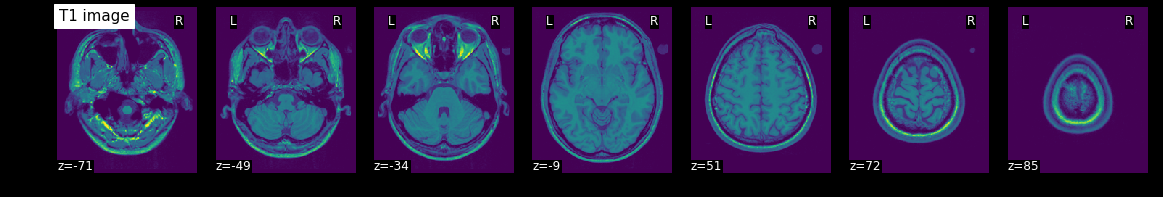

In [65]:
plot_epi(data_dir + 'sub_{}/t1w_{}.nii.gz'.format(idx,idx),
         title='T1 image', display_mode='z',
         cmap=plt.cm.viridis);

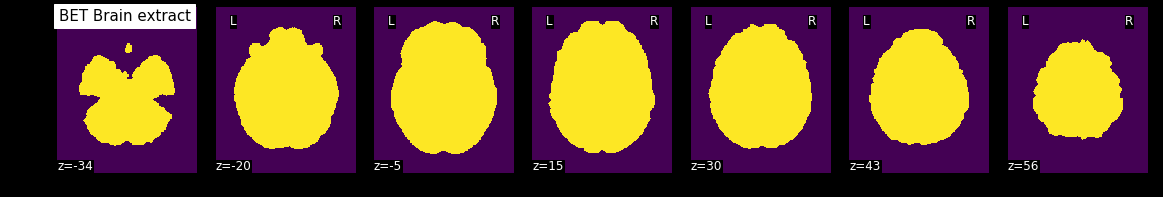

In [85]:
plot_epi(data_dir + 'sub_{}/BET_brain_anat_{}_mask.nii.gz'.format(idx,idx),
         title='BET Brain extract', display_mode='z',
         cmap=plt.cm.viridis);

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


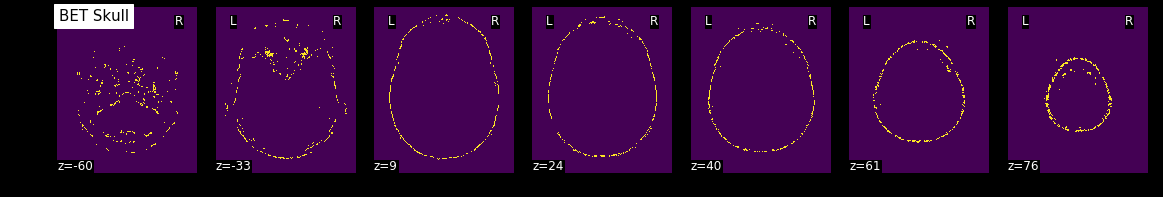

In [84]:
plot_epi(data_dir + 'sub_{}/BET_brain_anat_{}_skull.nii.gz'.format(idx,idx),
         title='BET Skull', display_mode='z',
         cmap=plt.cm.viridis);

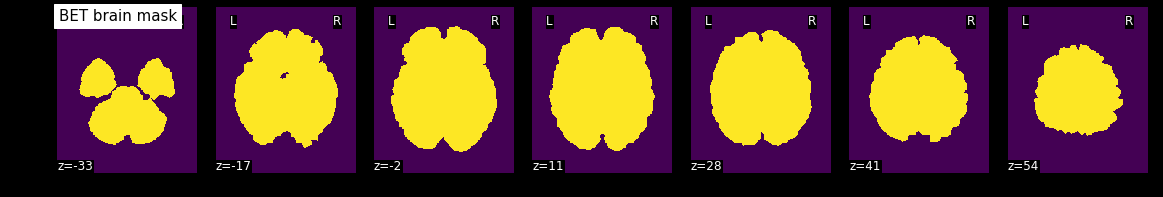

In [7]:
plot_epi('brain_anat_mask.nii.gz',
         title='BET brain mask', display_mode='z',
         cmap=plt.cm.viridis);